Surge from tropical cyclones modeled with GeoClaw
=================================================
Major damages from tropical cyclones (TC) are caused by coastal flooding from storm surge. Those damages are badly represented when using only windfields as a predictor. CLIMADA's `TCSurgeGeoClaw` class employs the geophysical flow solver [GeoClaw](http://www.clawpack.org/geoclaw) to predict TC surge damages at a resolution of up to 9 arc-seconds (approximately 270 meters, depending on latitude). For more information about GeoClaw, please refer to [the official web page](http://www.clawpack.org/geoclaw) and to the following publications:

* Berger, M. J., George,  D. L., LeVeque, R. J. and Mandli. K. M.: *The GeoClaw software for depth-averaged flows with adaptive refinement*, Advances in Water Resources 34 (2011), pp. 1195-1206. [DOI](https://doi.org/10.1016/j.advwatres.2011.02.016)
* Mandli, K. T. & Dawson, C. N.: *Adaptive Mesh Refinement for Storm Surge*. Ocean Modelling 75, 36–50 (2014). [DOI](https://doi.org/10.1016/j.ocemod.2014.01.002)

Performance warning
-------------------
Even though GeoClaw uses an efficient adaptive mesh refinement to model wave dynamics in the 2d depth-averaged shallow water equations, modeling storm surge is the computationally most challenging task included in CLIMADA. Computing the inundated areas from a single tropical cyclone might take between minutes and hours depending on the resolution, the storm and the host machine's resources.

Input data
----------
Three kinds of input data are required by `TCSurgeGeoClaw`: storm track, sea level and topographic data. CLIMADA's `TCTracks` class handles several kinds of TC track datasets, including best track data from the IBTrACS dataset of historical tropical cyclones. Sea level and topographic data have to be provided by the user in raster file format.

Since the quality of any storm surge model is dependent on good topographic data in coastal areas, it is highly recommended to choose the best regionally available **digital elevation model (DEM)** on a case-by-case basis instead of global DEMs such as SRTM. Note that, in this context, topography also includes bathymetry or underwater topography (sea floor). Bathymetry of sufficient quality is available as [SRTM15+V2.3](https://topex.ucsd.edu/WWW_html/srtm15_plus.html) or [GEBCO Gridded Bathymetry](https://www.gebco.net/data_and_products/gridded_bathymetry_data/). High-quality coastal DEM data is provided for the US coast by the [CoNED project](https://www.usgs.gov/land-resources/eros/coned). A global dataset with focus on coastal areas is [CoastalDEM](https://go.climatecentral.org/coastaldem/), but users should always consider regionally available sources on a case-by-case basis for better results. Note that, if several DEM datasets are combined, all of them need to be translated to the same reference geoid (so-called vertical datum), such as the geoid model EGM96.

The most severe damages from TC storm surge are caused by a combination of high seasonal tides and waves driven by TC winds. That's why `TCSurgeGeoClaw` requires **gridded sea surface height data** as an input. An at least monthly temporal resolution is required in order to take into account seasonal variability. Starting from 1993, monthly sea surface anomaly data from satellite altimetry is provided by the [Copernicus project](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview) The variable "Absolute dynamic topography" contains sea surface anomaly relative to the reference geoid "GOCO05s" (see Mulet et al. 2021) with monthly resolution. Make sure to reproject the data so that it is compatible with the reference geoid/vertical datum used in the DEM input (e.g. the geoid model EGM96).

Setup
-----
Note that this feature only works on Linux and Mac since Windows is not supported by GeoClaw. Due to the high computational demand, this functionality should be run on an HPC cluster with decent amounts of memory and processors (at least 32 GB and 8 cores) available. Only for testing purposes, it makes sense to run this functionality on a smaller machine at lower resolution, e.g. when running this tutorial notebook.

It is required to run the method `TCSurgeGeoClaw.from_tc_tracks` (or the function `climada_petals.hazard.tc_surge_geoclaw.setup_clawpack`) with a working internet connection at least once to trigger the download and installation of the flow solver (GeoClaw).

Moreover, before you can run several instances of this method in parallel, e.g. on an HPC cluster, make sure to run a single instance of this method since all instances of this method will be accessing the same version of the solver, and compilation might be triggered in all instances at the same time. The same applies if you want to recompile using the option `recompile=True`.

By default, the flow solver (GeoClaw) is configured to use multiple OpenMP threads with their number equal to the number of physical CPU cores in the machine. You can change this behavior by setting the environment variable `OMP_NUM_THREADS` to the desired number of threads. Note, however, that changes to `OMP_NUM_THREADS` will only be effective if you set `recompile=True` at least once.

Notes about this tutorial
-------------------------
This tutorial notebook computes coastal flooding caused by a single storm (Katrina, 2005) in a comparably small geographical region (New Orleans, Louisiana) at a comparably coarse spatial resolution (300 arc-seconds, or approximately 10 km). With this configuration, it should be possible to execute this tutorial on a personal laptop computer in a few minutes. However, in practice, it is advisable to choose a higher resolution (e.g. 30 arc-seconds), and run the flow solver on an HPC cluster node (e.g. with 16 CPU cores and 64 GB RAM).

In [1]:
# Choose project-specific sea level and topographic datasets

from climada.util.api_client import Client
client = Client()

# sample of Copernicus satellite altimetry for year 2005 and relative to EGM96 geoid
_, [ALTIMETRY_PATH] = client.download_dataset(
    client.get_dataset_info(name='tutorial_altimetry_gulf', status='package-data')
)

# sample from SRTM15+V2.3 combined bathymetry and topography at 300 arc-seconds resolution
_, [TOPO_PATH] = client.download_dataset(
    client.get_dataset_info(name='tutorial_bathymetry_gulf', status='package-data')
)

/home/tovogt/.local/share/miniconda3/envs/climada_env_3.9/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


2024-01-31 09:37:42,039 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-05-12 20:44:48 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/tovogt/.climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-01-31 09:37:42,934 - climada.hazard.tc_tracks - INFO - Progress: 100%


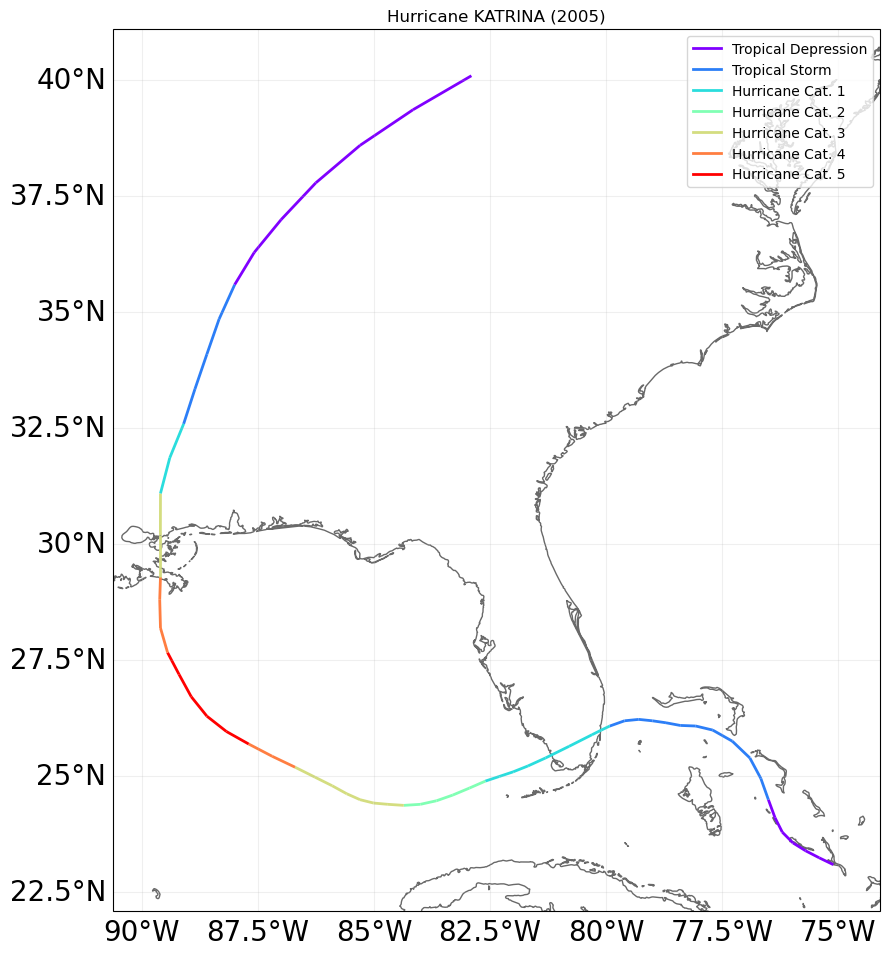

In [2]:
# storm track data is taken from IBTrACS
from climada.hazard.tc_tracks import TCTracks
tracks = TCTracks.from_ibtracs_netcdf(storm_id="2005236N23285")
tracks.plot().set_title('Hurricane KATRINA (2005)');

Running the GeoClaw surge model from CLIMADA
--------------------------------------------
For each run of GeoClaw, a working directory is created in `data/geoclaw/runs` in the CLIMADA data directory. Before the GeoClaw solver is run, the storm is analysed to predict which coastal areas are expected to be affected by the storm's surge. Furthermore, if a single storm involves multiple landfall events, each landfall event is modeled in a separate GeoClaw run. (Note that this example is only for a single landfall event to avoid long runtimes.)

Usually, it is not needed to inspect the internal working directories, but it is helpful for debugging purposes. The geographical areas of landfall are plotted and saved to a file `event_areas.pdf` in the working directory (also plotted inline below). Furthermore, plots of the DEM data used for each GeoClaw run are generated and saved to files `dems.pdf` in subdirectories of the working directory (also plotted inline below).

2024-01-31 09:37:47,030 - climada_petals.hazard.tc_surge_geoclaw - INFO - Reading sea level data from altimetry_2005.nc
2024-01-31 09:37:47,041 - climada_petals.hazard.tc_surge_geoclaw - INFO - Sea level data available within bounds (261.125, 16.125, 281.875, 43.875)
2024-01-31 09:37:47,044 - climada_petals.hazard.tc_surge_geoclaw - INFO - Sea level data available within period from 2005-08 till 2005-10
2024-01-31 09:37:47,096 - climada_petals.hazard.tc_surge_geoclaw - INFO - Found Clawpack version 5.9.2 in /home/tovogt/.climada/data/geoclaw/src/clawpack
2024-01-31 09:37:47,163 - climada.util.coordinates - INFO - Sampling from /home/tovogt/.climada/data/GMT_intermediate_coast_distance_01d.tif
2024-01-31 09:37:47,251 - climada_petals.hazard.tc_surge_geoclaw - INFO - Computing TC surge of 1 tracks on 5289 centroids.
2024-01-31 09:37:47,253 - climada.util.coordinates - INFO - Sampling from srtm_300as.tif
2024-01-31 09:37:47,275 - climada_petals.hazard.tc_surge_geoclaw - INFO - Determine g

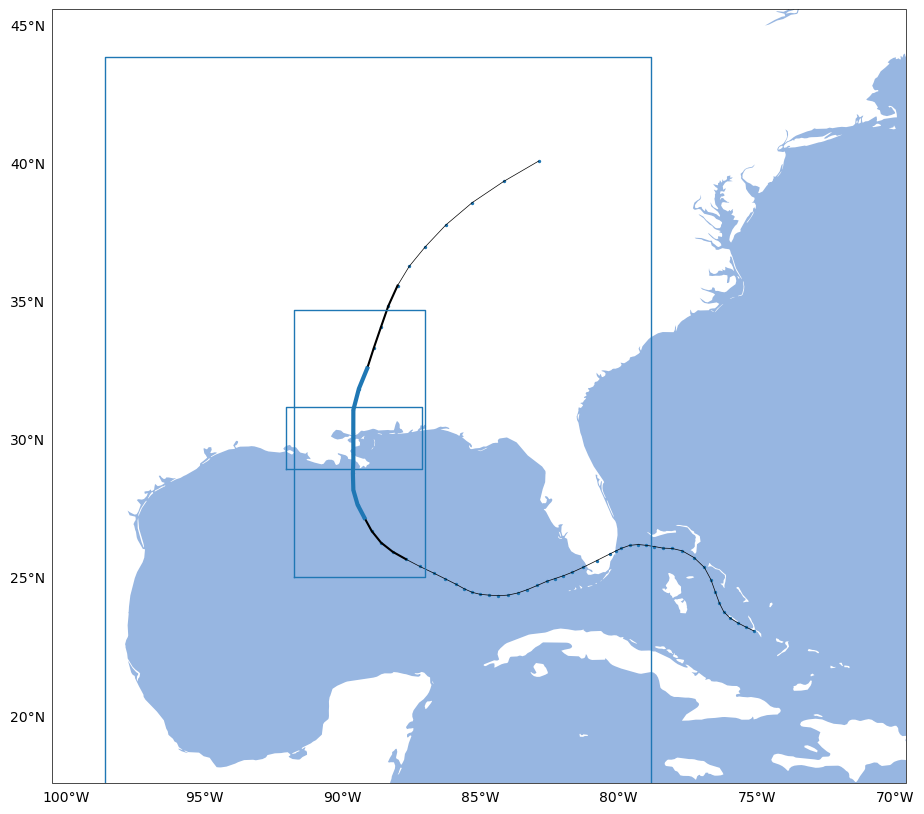

2024-01-31 09:37:49,800 - climada_petals.hazard.tc_surge_geoclaw - INFO - Starting 1 runs of GeoClaw ...
2024-01-31 09:37:49,802 - climada_petals.hazard.tc_surge_geoclaw - INFO - Prepare GeoClaw to determine surge on 1967 centroids
2024-01-31 09:37:49,805 - climada_petals.hazard.tc_surge_geoclaw - INFO - Init GeoClaw working directory: /home/tovogt/.climada/data/geoclaw/runs/2024-01-31-09374752-2005236N23285/2005-08-29-00
2024-01-31 09:37:49,806 - climada_petals.hazard.tc_surge_geoclaw - INFO - Found Clawpack version 5.9.2 in /home/tovogt/.climada/data/geoclaw/src/clawpack
2024-01-31 09:37:49,846 - climada_petals.hazard.tc_surge_geoclaw - INFO - GeoClaw resolution in arc-seconds: ['889.75', '444.88', '222.44', '74.15']
2024-01-31 09:37:49,881 - climada_petals.hazard.tc_surge_geoclaw - INFO - Load elevation data [360, (-98.59017181396484, 16.817861557006836, -78.81785583496094, 43.86089324951172)] from srtm_300as.tif
2024-01-31 09:37:49,929 - climada_petals.hazard.tc_surge_geoclaw - INF

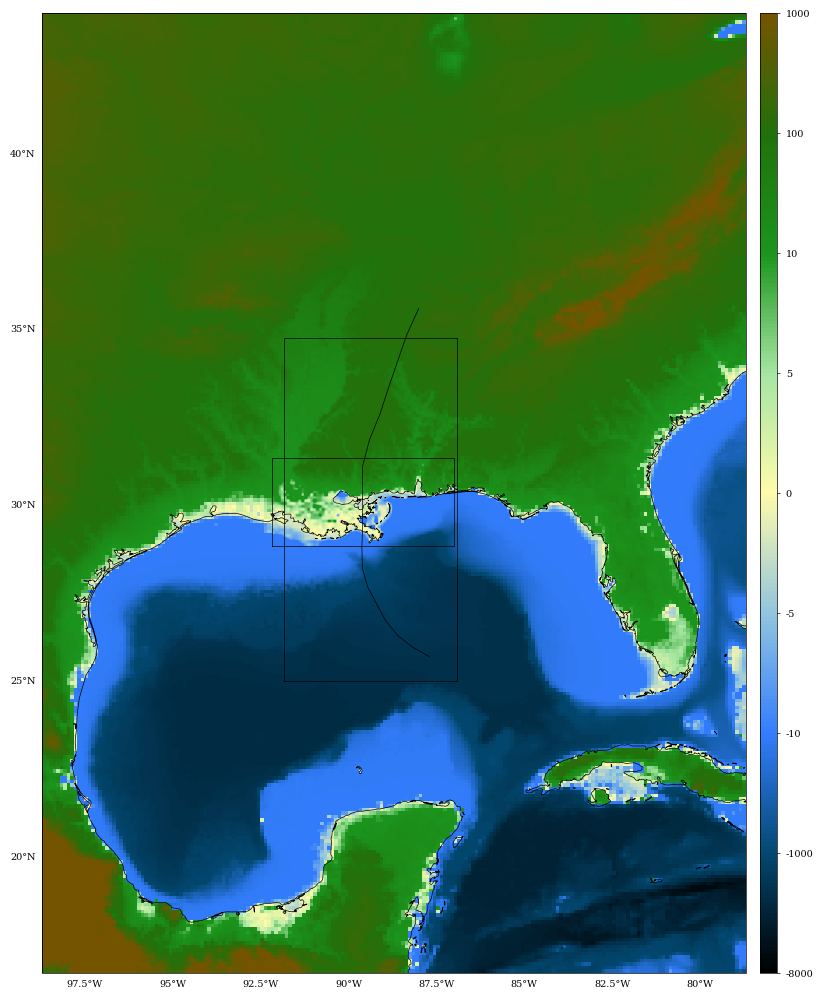

2024-01-31 09:37:51,591 - climada_petals.hazard.tc_surge_geoclaw - INFO - Running GeoClaw in /home/tovogt/.climada/data/geoclaw/runs/2024-01-31-09374752-2005236N23285/2005-08-29-00 ...
2024-01-31 09:37:52,409 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 0%
2024-01-31 09:38:06,493 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 10%
2024-01-31 09:38:19,996 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 20%
2024-01-31 09:38:30,294 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 30%
2024-01-31 09:38:37,937 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 40%
2024-01-31 09:38:47,096 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 50%
2024-01-31 09:38:54,911 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 60%
2024-01-31 09:39:01,754 - climada_petals.hazard.tc_surge_geoclaw - INFO - 2005-08-29-00: 70%
2024-01-31 09:39:07,986 - climada_petals.hazard.tc_surge_geoclaw - INFO 

In [3]:
from climada.hazard import Centroids
from climada_petals.hazard.tc_surge_geoclaw import TCSurgeGeoClaw, sea_level_from_nc

# bounds : box around New Orleans, Louisiana:
bounds = (-95, 25, -85, 35)

# Note that the resolution of the centroids does not affect the internal resolution of the flow solver.
# In this example, we take a resolution of 150 arc-seconds for the centroids, but the internal
# resolution of the flow solver will only depend on the resolution of the topography.
centroids = Centroids.from_pnt_bounds(bounds, res=150 / (60 * 60))

# sea_level_fun : function that extracts sea level from a file for a given
#                 temporal period and spatial bounds
sea_level_fun = sea_level_from_nc(ALTIMETRY_PATH)

# The internal resolution of the flow solver is automatically adjusted to the `topo_res_as` keyword argument.
# It is always chosen to be one order of magnitude higher than `topo_res_as` (e.g. ~75 arc-seconds for topo_res_as=300).
# If the specified topography data has higher resolution, it will be aggregated to `topo_res_as`.
haz = TCSurgeGeoClaw.from_tc_tracks(
    tracks, centroids, TOPO_PATH,
    max_dist_offshore_km=5,
    geoclaw_kwargs=dict(
        topo_res_as=300,
        sea_level=sea_level_fun,
    ),
)

2024-01-31 09:39:18,761 - climada.hazard.base - INFO - Writing tc_surge_katrina_2005.h5


<GeoAxes: title={'center': 'TCSurgeGeoClaw max intensity at each point'}>

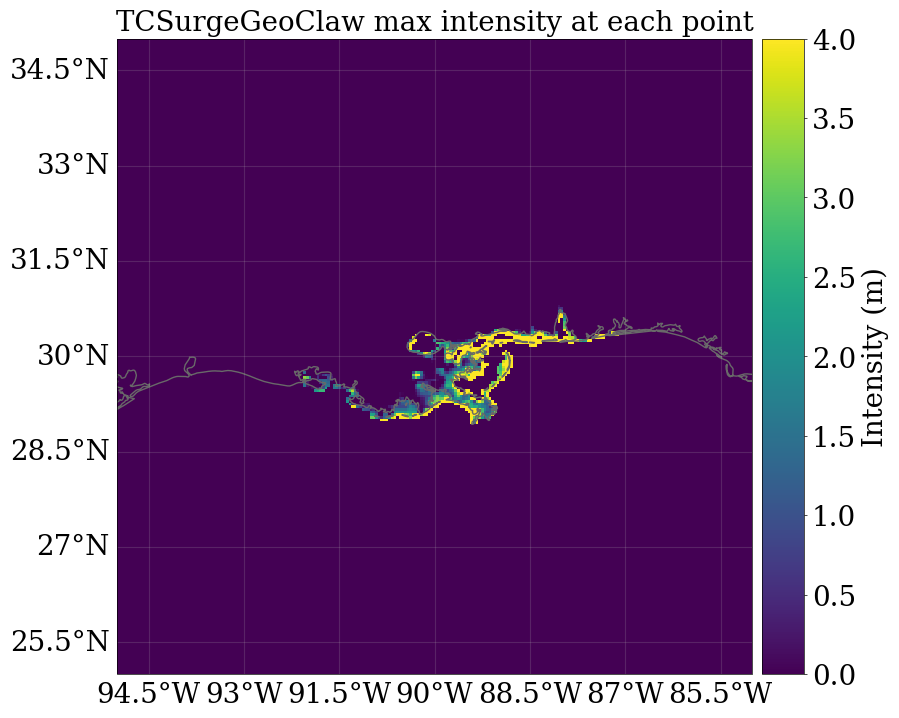

In [4]:
# The Hazard object can be used just like any other Hazard object, e.g.:
haz.write_hdf5("tc_surge_katrina_2005.h5")
haz.plot_intensity(event=0, smooth=False, vmin=0, vmax=4)